In [1]:
from torch_geometric.datasets import QM9
import matplotlib.pyplot as plt
import seaborn

In [2]:
dataset = QM9(root=f'./data/QM9').y

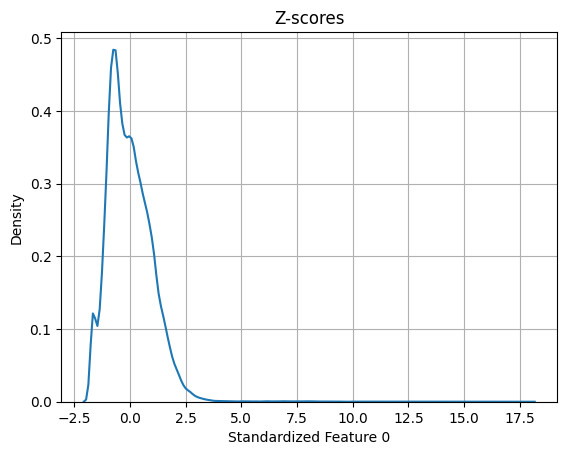

In [3]:
i = 0   # i in {0..18}

y = dataset[:, i]
y = (y-y.mean()) / (y.std())
seaborn.kdeplot(x=y)
plt.xlabel(f'Standardized Feature {i}')
plt.title('Z-scores')
plt.grid()
plt.show()

In [4]:
import os
from collections import defaultdict
from itertools import product
import numpy as np
from utils.parse_logs import parse_configs, parse_metrics
from utils.format import format_dataset_name, format_layer_name, format_dropout_name, format_task_name

In [5]:
PAR_DIR = 'results/compare-dropout'
DATASETS = ['QM9', 'Proteins', 'PTC', 'MUTAG']
MODELS = ['GCN', 'GAT']
DROPOUTS = ['Dropout', 'DropNode', 'DropEdge', 'DropMessage']
DROP_PS = np.arange(0.1, 1.0, 0.1).tolist()
METRICS = ['Mean Squared Error', 'Accuracy', 'Accuracy', 'Accuracy']

results = defaultdict(lambda: {dropout: [None for _ in DROP_PS] for dropout in DROPOUTS})

for exp_dir in os.listdir(PAR_DIR):

    exp_dir = f'{PAR_DIR}/{exp_dir}'
    config = parse_configs(f'{exp_dir}/logs')
    dataset = format_dataset_name[config['dataset'].lower()]
    model = format_layer_name[config['gnn'].lower()]
    dropout = format_dropout_name[config['dropout'].lower()]
    if dataset not in DATASETS or model not in MODELS or dropout not in DROPOUTS:
        continue
    
    task = format_task_name[config['task'].lower()]
    if task.endswith('C'):
        metric = 'Accuracy'; np_arg = np.argmax
    elif task.endswith('R'):
        metric = 'Mean Squared Error'; np_arg = np.argmin
    train, val, test = parse_metrics(f'{exp_dir}/logs')
    metric = METRICS[DATASETS.index(dataset)]
    best_epoch = np_arg(val[metric])
    es_test_metric = test[metric][best_epoch]
    idx = int(float(config['drop_p'])*10)-1
    results[(dataset, model)][dropout][idx] = es_test_metric

results = dict(results)

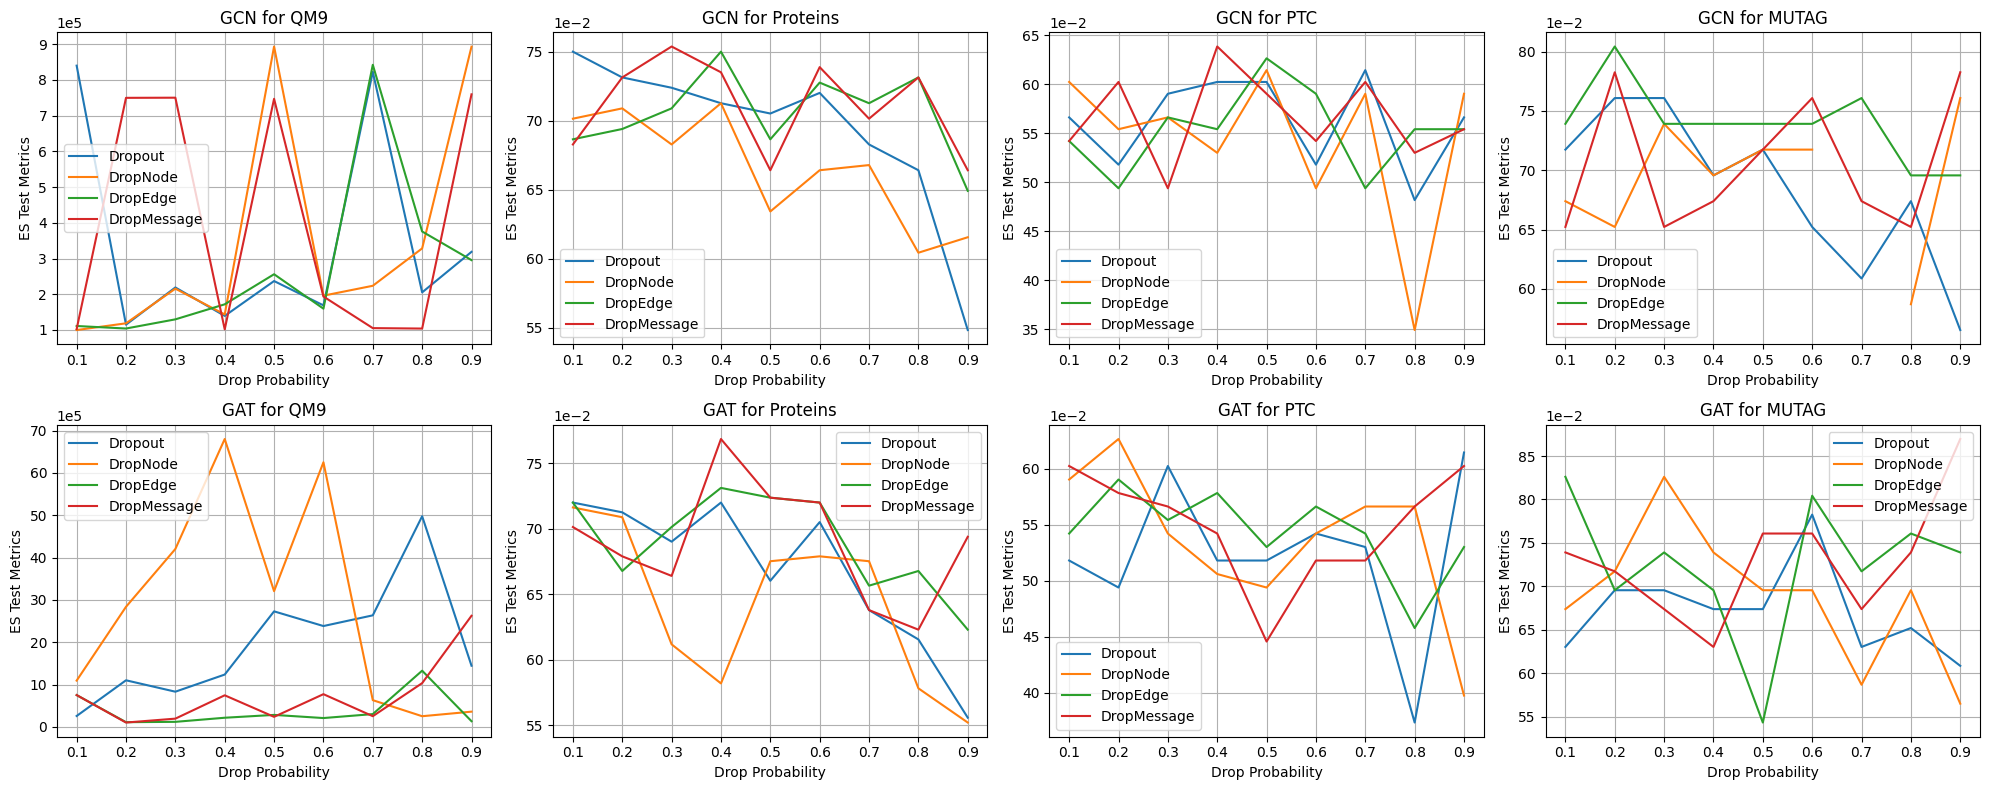

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i, (model, dataset) in enumerate(product(MODELS, DATASETS)):
    ax = axs[i//4, i%4]
    result = results[(dataset, model)]
    for dropout in DROPOUTS:
        ax.plot(DROP_PS, result[dropout], label=dropout)
    ax.set_xlabel('Drop Probability')
    ax.set_ylabel('ES Test Metrics')
    ax.set_title(f'{model} for {dataset}')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(5, 5) if i%4 == 0 else (-2, -2))
    ax.grid()
    ax.legend()

fig.tight_layout()
plt.show()

In [25]:
PAR_DIR = 'results/compare-dropout'
DATASETS = ['QM9', 'Proteins', 'PTC', 'MUTAG']
MODELS = ['GCN', 'GAT']
DROPOUT = 'DropEdge'
DROP_PS = np.round(np.arange(0.2, 1.0, 0.3), 1).tolist()

results = defaultdict(lambda: [None for _ in DROP_PS])

for exp_dir in os.listdir(PAR_DIR):

    exp_dir = f'{PAR_DIR}/{exp_dir}'
    config = parse_configs(f'{exp_dir}/logs')
    dataset = format_dataset_name[config['dataset'].lower()]
    model = format_layer_name[config['gnn'].lower()]
    dropout = format_dropout_name[config['dropout'].lower()]
    drop_p = float(config['drop_p'])
    if dataset not in DATASETS or model not in MODELS or dropout != DROPOUT or drop_p not in DROP_PS:
        continue
    task = format_task_name[config['task'].lower()]
    if task.endswith('C'):
        metric = 'Accuracy'
    elif task.endswith('R'):
        metric = 'Mean Squared Error'
    train, val, test = parse_metrics(f'{exp_dir}/logs')
    idx = DROP_PS.index(drop_p)
    results[(dataset, model)][idx] = train[metric]

results = dict(results)

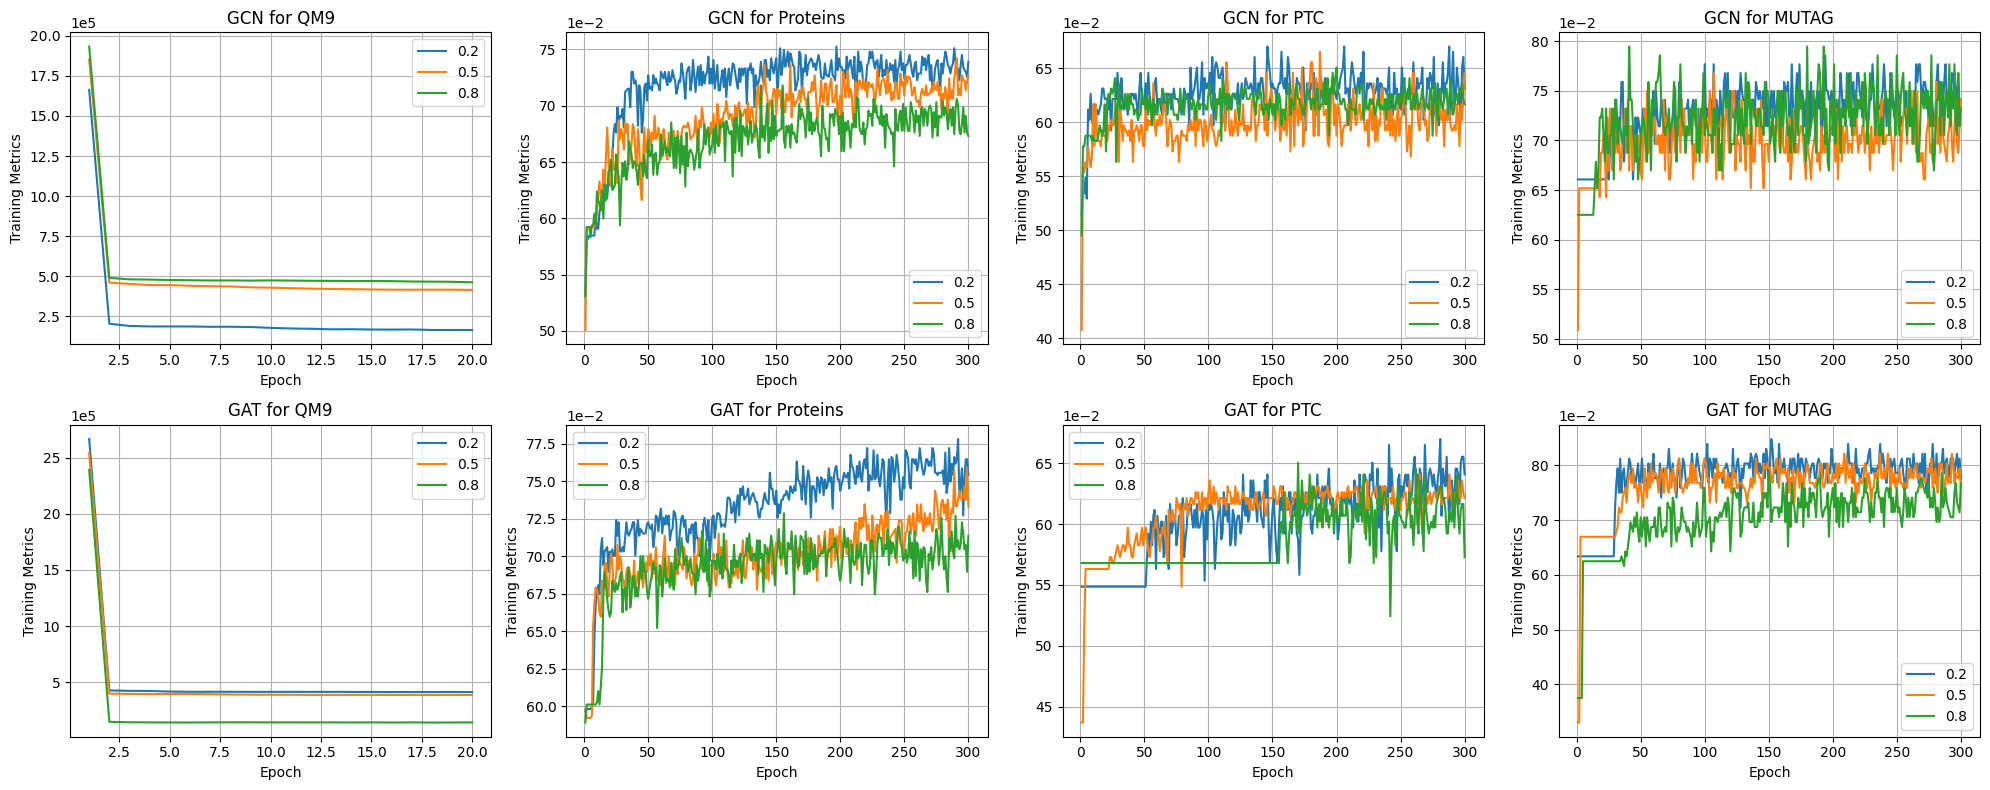

In [26]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i, (model, dataset) in enumerate(product(MODELS, DATASETS)):
    ax = axs[i//4, i%4]
    result = results[(dataset, model)]
    for drop_p, metrics in zip(DROP_PS, result):
        ax.plot(np.arange(1, len(metrics)+1), metrics, label=drop_p)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Metrics')
    ax.set_title(f'{model} for {dataset}')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(5, 5) if i%4 == 0 else (-2, -2))
    ax.grid()
    ax.legend()

fig.tight_layout()
plt.show()

In [17]:
import os
from collections import Counter
from utils.parse_logs import parse_configs

In [24]:
PAR_DIR = 'results/drop-edge/long-range'
exps = list()
for exp_dir in os.listdir(PAR_DIR):
    logs = f'{PAR_DIR}/{exp_dir}/logs'
    config = parse_configs(logs)
    if config['gnn'] == 'GCN':
        exps.append((len(eval(config['gnn_layer_sizes'])), config['drop_p']))

sorted([(k, v) for k, v in Counter(exps).items() if v < 5])

[((8, '0.9'), 4)]